# Entity extraction on Financial Complaints with Watson NLP

This notebook demonstrates how to extract _named entities_ from financial customer complaints using Watson NLP.

The data that is used in this notebook is taken from the Consumer Complaint Database that is published by the Consumer Financial Protection Bureau (CFPB), an U.S. government agency. The Consumer Complaint Database is a collection of complaints about consumer financial products and services that the CFPB sent to companies for response.  A complaint contains a consumer’s narrative description of their experience if the consumer opts to share this information publicly and after the CFPB has taken steps to remove all personal information. In this notebook, you will focus on complaints that contain narrative descriptions to show how to use Watson NLP.

The data is publicly available at https://www.consumerfinance.gov/data-research/consumer-complaints/.

## What you'll learn in this notebook

Watson NLP offers so-called blocks for various NLP tasks. This notebooks shows:

- **Dictionary-based term extraction** with the _Rule-based extractor_ provided by `watson_nlp.resources.feature_extractor.RBR`. This allows you to train a custom extraction model based on given dictionaries.

- **Entity extraction** with the _Entity mentions block_ using the BERT model (`entity-mentions_bert_multi_stock`). This block extracts mentions of entities like *Persion*, *Organization* or *Duration* from the input text.


## Table of Contents

1.	[Before you start](#beforeYouStart)
2.	[Load the complaints](#loadData)
3.  [Custom term extraction using dictionaries](#dictionaries)
4.  [Entity extraction](#entities)
5.  [Summary](#summary)

<a id="beforeYouStart"></a>
## Before you start

You can step through the notebook execution cell by cell, by selecting Shift-Enter or you can execute the entire notebook by selecting **Cell -> Run All** from the menu. 

**Note:** If you have other notebooks currently running with the _NLP_ environment, **stop their kernels** before running this notebook. All these notebooks share the same runtime environment, and if they are running in parallel, you may encounter memory issues. To stop the kernel of another notebook, open that notebook, and select _File > Stop Kernel_.


Begin by importing and initializing some helper libraries that are used throughout the notebook.

In [1]:
from tqdm import tqdm

In [2]:
import os
import pandas as pd
# we want to show large text snippets to be able to explore the relevant text
pd.options.display.max_colwidth = 400

In [3]:
import watson_nlp

<a id="loadData"></a>
## Load the complaints

The data can be downloaded via an API from https://www.consumerfinance.gov/data-research/consumer-complaints/. For this notebook, the complaints for one month will be downloaded and only those that contain the consumer narrative text. The data is exported in CSV format. The URL to retrieve this data is:

In [4]:
url = "https://www.consumerfinance.gov/data-research/consumer-complaints/search/api/v1/?date_received_max=2021-03-30&date_received_min=2021-02-28&field=all&format=csv&has_narrative=true&no_aggs=true&size=18102"

Read the data into a dataframe.

You can find a detailed explanation of the available columns here: https://www.consumerfinance.gov/complaint/data-use/#:~:text=Types%20of%20complaint%20data%20we%20publish .

In the analysis, you will focus on the *Product* column and the column with the complaint text *Consumer complaint narrative*.

In [5]:
df_all = pd.read_csv(url)
text_col = 'Consumer complaint narrative'

# In this example, we take only the first 1000 complaints in the dataset for further analysis. 
# Set df to df_all to run on the complete dataset.
df_small = df_all.head(1000)
df = df_small
df.head(3)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,03/24/21,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Incorrect information on your report,Information belongs to someone else,Ive failed a dispute in regards to the incorrect items on my credit report it has been well over 30 days and I havent received any investigation results.,None,"EQUIFAX, INC.",PA,19143,None,Consent provided,Web,03/24/21,Closed with explanation,Yes,NaN,4239946
1,03/01/21,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Problem with a credit reporting company's investigation into an existing problem,Was not notified of investigation status or results,"On the XX/XX/XXXX, I sent in letters regarding inaccurate reporting of false items on my credit report. I have not received their method of verification nor the results of their investigation. I feel like I'm being ignored of my claims and disputes. These are deceptive practices of the bureaus.",Company has responded to the consumer and the CFPB and chooses not to provide a public response,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",FL,33029,None,Consent provided,Web,03/01/21,Closed with explanation,Yes,NaN,4173173
2,03/06/21,Credit card or prepaid card,General-purpose credit card or charge card,Problem when making payments,Problem during payment process,"This is part 2 of a partially resolved issue. \n\nAfter issue 1 ( CFPB # : XXXX ) was resolved, I was not given a refund for my overpayments which were made to ensure there would be no incorrect reporting to the credit agencies. \n\nThe original purchase was made during a promotional period, 18 months interest free. I paid the the purchase off in 18 months, but was forced to make 19 payments t...",Company has responded to the consumer and the CFPB and chooses not to provide a public response,BARCLAYS BANK DELAWARE,WA,98109,None,Consent provided,Web,03/06/21,Closed with explanation,Yes,NaN,4189350


You can look at all products that are available in the data set to do further analysis around these product groups.

<AxesSubplot:>

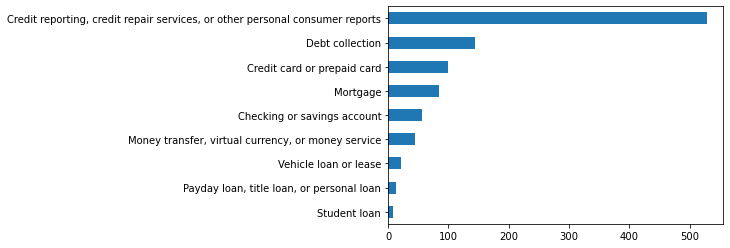

In [6]:
df['Product'].value_counts().sort_values().plot(kind='barh') 

<a id="dictionaries"></a>
## Custom term extraction using dictionaries

If you want to extract custom concepts via rule-based extraction, you can build a custom RBR model using an AQL model. However this requires knowledge of AQL. If you just want to extract custom terms or match regular expression patterns, there is a convenient way to train and run such models through `watson_nlp.resources.feature_extractor.RBR`. You only need to provide your own dictionaries or regexes and it trains an RBR model for you.

You will now create a basic dictionary that contains terms that might indicate customers suspecting a fraud concerning their financial products like the theft of a credit card.

Start with creating a folder that holds all dictionary files that you want to use for extraction.

In [7]:
import os
RBR_dicts_folder = "RBR_dicts"
os.makedirs(RBR_dicts_folder, exist_ok=True)

A dictionary can contain the dictionary terms as a flat list if all the terms are to be mapped to the same label. Alternatively, you can use a mapping dictionary that maps terms to a label. 

In this notebook, you will create a dictionary mapping file containing the fraud-related terms divided into *FRAUD* and *THEFT*. Each line has one dictionary entry.

In [8]:
fraud_file = "fraud_mappings.csv"
with open(os.path.join(RBR_dicts_folder, fraud_file), 'w') as dict:
    dict.write("\"label\", \"entry\"\n")
    dict.write("\"FRAUD\", \"fraud\"\n")
    dict.write("\"FRAUD\", \"takeover\"\n")
    dict.write("\"FRAUD\", \"skimming\"\n")
    dict.write("\"FRAUD\", \"phishing\"\n")
    dict.write("\"THEFT\", \"theft\"\n")
    dict.write("\"THEFT\", \"thief\"\n")
    dict.write("\"THEFT\", \"thieve\"\n")
    dict.write("\"THEFT\", \"steal\"\n")

In the next step, load the file as dictionary. The source dictionary path is a relative path to the created dictionary resources folder. You will use case-insensitive matching as the dictionary entries are regular words that are not likely to be miss-interpreted.

Lemma-matching will make sure that inflections of the dictionary entries will also match, for example, "steal" -> "stole", "stolen", "stealing".

In [9]:
from watson_nlp.toolkit import DictionaryConfig

dictionary = DictionaryConfig.load( 
    {
        'name': 'fraud_mappings',
        'source': fraud_file,
        'dict_type': 'table',
        'case': 'insensitive',
        'lemma': True,
        'mappings': {
            'columns': ['label', 'entry'],
            'entry': 'entry'
        }
    }
)

Train the RBR model using the created dictionary. This will create the unterlying AQL code.

In [10]:
trained_dict_RBR = watson_nlp.resources.feature_extractor.RBR.train(RBR_dicts_folder, language='en', dictionaries=[dictionary,])

As for the other demonstrated blocks before, create a helper method to run the RBR model on a single complaint. There is a `run()` method on the trained model, which returns the extracted concept and the span specifying the covered text.
But as you also want to see the covered text immediatly, you will access the raw response from the underlying RBR executor.

In [11]:
def extract_dictionary(complaint_text):
    RBR_result = trained_dict_RBR.executor.get_raw_response(complaint_text, language='en')
    # aggregate all matches into one array with the match label and the text evidence
    matches = []
    for view in RBR_result['annotations'].keys():
        for dict_match in RBR_result['annotations'][view]:
            matches.append(tuple((dict_match['label'], dict_match['match']['text'])))
    return matches

Now run the dictionary extraction on the complete dataframe and display the results with the complaint text.

In [12]:
# run dictionary extraction and create a dataframe holding the results
dict_matches = df[text_col].apply(lambda text: extract_dictionary(text))
dict_matches_df = pd.DataFrame(dict_matches)
dict_matches_df.rename(inplace=True, columns={text_col:'Fraud Indicators'})
# combine with the complaint dataframe
text_dict_matches_df = df[["Product", text_col]].merge(dict_matches_df, how='left', left_index=True, right_index=True)
text_dict_matches_df.head(10)

,Product,Consumer complaint narrative,Fraud Indicators
0,"Credit reporting, credit repair services, or other personal consumer reports",Ive failed a dispute in regards to the incorrect items on my credit report it has been well over 30 days and I havent received any investigation results.,[]
1,"Credit reporting, credit repair services, or other personal consumer reports","On the XX/XX/XXXX, I sent in letters regarding inaccurate reporting of false items on my credit report. I have not received their method of verification nor the results of their investigation. I feel like I'm being ignored of my claims and disputes. These are deceptive practices of the bureaus.",[]
2,Credit card or prepaid card,"This is part 2 of a partially resolved issue. \n\nAfter issue 1 ( CFPB # : XXXX ) was resolved, I was not given a refund for my overpayments which were made to ensure there would be no incorrect reporting to the credit agencies. \n\nThe original purchase was made during a promotional period, 18 months interest free. I paid the the purchase off in 18 months, but was forced to make 19 payments t...",[]
3,Mortgage,"My loan was in default due to illness, We filed a Chapter XXXX in XXXX Bankruptcy Court and paid on the plan for 3 years, We were able to get a short term loan to Buyout the Chapter XXXX, When we received the payoff letter the mortgage company had added {$14000.00} in fees that we had never been invoiced for and were not included the bankruptcy proof of claim. i contacted the mortgage company ...",[]
4,"Credit reporting, credit repair services, or other personal consumer reports","I saw an account pop up on my credit report listing me as an authorized user for a credit card account with XXXX. I do not have a credit card with XXXX, I have not applied for credit with XXXX, and I have no knowledge of this account with XXXX. I started a dispute through Experian and XXXX online. The results came back that the entry remains. I contacted XXXX and they have searched my social ...",[]
5,"Credit reporting, credit repair services, or other personal consumer reports",Theyre reporting late payments on a second mortgage. We got out of bankruptcy but no one told us to resume making payments to the bank we tried paying the trustee as we had been and when we talked to XXXX XXXX they said they would fix it but never did. If you look at our payment history we have never been late on our mortgage payment. It was not our fault as we had no direction from the truste...,[]
6,Mortgage,Was not aware that Wyndham Capital Mortgage would sell my loan to a very shady company with a horrible rating -- XXXX XXXX. Now I have to stay with them or incur the cost of refinancing to have a new mortgage company. I think there should be more regulations in place and consumers should be made aware of such practices -- actually having to sign documents before such transactions between compa...,[]
7,Vehicle loan or lease,My vehicle was repossessed due to failure to make payments for a separate insurance coverage that I declined from the the begging of the contract. I have been covered by XXXX 3+years I stated from the beginning I didnt need the CPI. So how is my vehicle being repossessed for failure to pay for a service that I declined? I tried for 3 days to speak with management. When I finally was able to sp...,"[(THEFT, steal)]"
8,Debt collection,"I've sent multiple letters to this agency about this not being my account. After being advised by identitytheft.gov, I've completed and sent a fraud affidavit via certified mail. I can see they received it, but nothing has changed. See supporting documents. Even the USPS tracking. My official complaint is against PORTFOLIO RECOVERY. My information was used to obtain an apartment, cell phone, a...","[(FRAUD, fraud), (THEFT, theft), (THEFT, theft)]"
9,"Money transfer, virtual currency, or money service",On XX/XX/2020 I received an email from PayPal stating that my account was currently limited and that i had to take some st

Notice that "stolen" was detected as *THEFT* as the base-form *steal* is contained in the dictionary and you used lemma-matching.

How many complaints talk about *THEFT* or *FRAUD* or both? Count the complaints for each product group and display the relative frequency: 

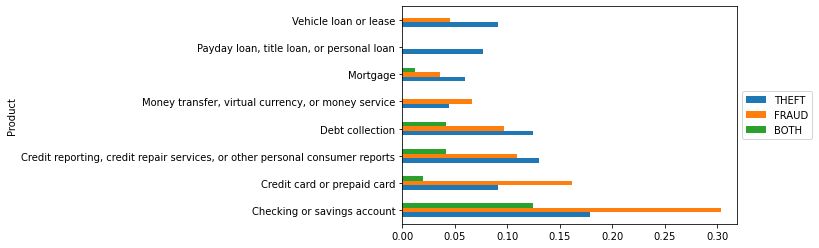

In [13]:
# create a column indicating if the complaint contains at least one *FRAUD* or *THEFT* match
text_dict_matches_df['THEFT'] = text_dict_matches_df['Fraud Indicators'].apply(lambda matches: 'THEFT' in set([match[0] for match in matches]))
text_dict_matches_df['FRAUD'] = text_dict_matches_df['Fraud Indicators'].apply(lambda matches: 'FRAUD' in set([match[0] for match in matches]))
text_dict_matches_df['BOTH'] = text_dict_matches_df['Fraud Indicators'].apply(lambda matches: 'FRAUD' in set([match[0] for match in matches]) and 'THEFT' in set([match[0] for match in matches]))

# get the relative frequency by product group
perc_theft = text_dict_matches_df.groupby('Product')['THEFT'].value_counts(normalize=True)
perc_fraud = text_dict_matches_df.groupby('Product')['FRAUD'].value_counts(normalize=True)
perc_both = text_dict_matches_df.groupby('Product')['BOTH'].value_counts(normalize=True)
# combine the values into one dataframe
res = pd.concat([perc_theft, perc_fraud, perc_both], axis=1).reset_index().rename(columns={"level_1": "is_contained"})
# only use the counts for rows indicating a match
res = res[res['is_contained']].drop('is_contained', axis=1).set_index('Product')
res.plot.barh().legend(loc='center left',bbox_to_anchor=(1.0, 0.5))


Nearly 15% of the Money transfer/service complaints seem to deal with theft and over 25% of the checking or savings account complaints with fraud.

<a id="entities"></a>
## Entity extraction

The complaints contain a lot of entity mentions about entities like organizations, money, durations, etc. In this section you will learn how to use the BERT entity mention extraction block, which extracts entity mentions out-of-the-box. 

The BERT entity mention model depends on the syntax model. Start with loading both models:

In [14]:
syntax_model = watson_nlp.load('syntax_izumo_en_stock')
bert_entity_model = watson_nlp.load('entity-mentions_bert_multi_stock')

The helper method first runs the syntax model and then the entity extraction model on top of the syntax result:

In [15]:
def extract_entities(complaint_text):
    # run syntax model
    syntax_result = syntax_model.run(complaint_text, parsers=('token', 'lemma', 'part_of_speech'))
    # run the entity mention model on the result of the syntax model
    entity_mentions = bert_entity_model.run(syntax_result)
    # get text and type of entities
    entities = entity_mentions.get_mention_pairs()
    return entities

Run the entity extraction model on the complaint dataframe and show the extracted entities along with the complaint text.<br/> **Note:** This cell will run for several minutes. For better progress feedback, the cell is using `progress_apply` from the `tqdm` library. You can also use `apply` from `pandas` directly, i.e. `df[text_col].apply(..)`

In [16]:
from tqdm.notebook import tqdm
tqdm.pandas(colour='green')

In [17]:
# run entity extraction and create a dataframe holding the results
entities = df[text_col].progress_apply(lambda text: extract_entities(text))
entities_df = pd.DataFrame(entities)
entities_df.rename(inplace=True, columns={text_col:'Entities'})
# combine with our complaint dataframe
text_entities_df = df[["Product", text_col]].merge(entities_df, how='left', left_index=True, right_index=True)
text_entities_df.head()

  0%|          | 0/1000 [00:00<?, ?it/s]

,Product,Consumer complaint narrative,Entities
0,"Credit reporting, credit repair services, or other personal consumer reports",Ive failed a dispute in regards to the incorrect items on my credit report it has been well over 30 days and I havent received any investigation results.,"[(Ive, Person), (30 days, Duration)]"
1,"Credit reporting, credit repair services, or other personal consumer reports","On the XX/XX/XXXX, I sent in letters regarding inaccurate reporting of false items on my credit report. I have not received their method of verification nor the results of their investigation. I feel like I'm being ignored of my claims and disputes. These are deceptive practices of the bureaus.",[]
2,Credit card or prepaid card,"This is part 2 of a partially resolved issue. \n\nAfter issue 1 ( CFPB # : XXXX ) was resolved, I was not given a refund for my overpayments which were made to ensure there would be no incorrect reporting to the credit agencies. \n\nThe original purchase was made during a promotional period, 18 months interest free. I paid the the purchase off in 18 months, but was forced to make 19 payments t...","[(18 months, Duration), (18 months, Duration), ($190.00, Money), ($3300.00, Money), ($190.00, Money)]"
3,Mortgage,"My loan was in default due to illness, We filed a Chapter XXXX in XXXX Bankruptcy Court and paid on the plan for 3 years, We were able to get a short term loan to Buyout the Chapter XXXX, When we received the payoff letter the mortgage company had added {$14000.00} in fees that we had never been invoiced for and were not included the bankruptcy proof of claim. i contacted the mortgage company ...","[(XXXX, Organization), (Bankruptcy Court, Organization), (3 years, Duration), ($14000.00, Money), (XXXX, Location), (XXXX, Date), (30 days, Duration), (XXXX, Date), (3rd, Ordinal), (Yesterday, Date), (30 days, Duration)]"
4,"Credit reporting, credit repair services, or other personal consumer reports","I saw an account pop up on my credit report listing me as an authorized user for a credit card account with XXXX. I do not have a credit card with XXXX, I have not applied for credit with XXXX, and I have no knowledge of this account with XXXX. I started a dispute through Experian and XXXX online. The results came back that the entry remains. I contacted XXXX and they have searched my social ...","[(Experian, Organization), (XXXX, Organization)]"


Let's see what kind of entities are extracted from the complaints:

<AxesSubplot:>

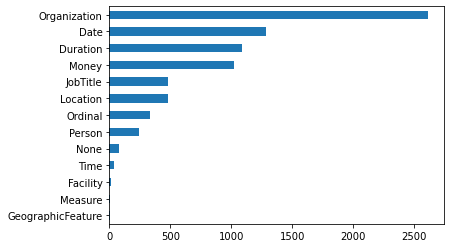

In [18]:
# helper method to extract the mention type from the (text, type) tuple
def get_entity_type(ent):
    if not pd.isna(ent):
        return ent[1]
    return 'None'

# create separate rows for each entity mention
exp_entities = text_entities_df.explode('Entities')
# extract the entity type of each mention
exp_entities['Entity Type'] = exp_entities['Entities'].apply(lambda ent: get_entity_type(ent))
# count the number of occurrences for each entity type
exp_entities['Entity Type'].value_counts().head(20).sort_values().plot(kind='barh') 

Show the relative frequency of each entity type by product:

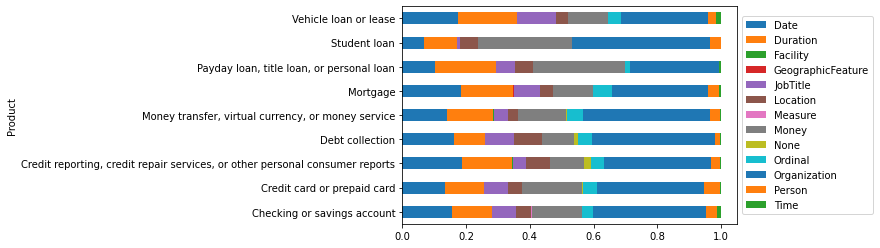

In [19]:
unstacked = exp_entities.groupby('Product')['Entity Type'].value_counts(normalize=True).unstack()
unstacked.plot.barh(stacked=True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

*Job Titles* are frequently mentioned in the *Vechicle loan or lease* product group and there is a high number of *Location* mentions for the product group *Debt collection*. Let's look at some sample texts for the job titles:

In [20]:
exp_entities.query('`Entity Type` == "JobTitle" and Product == "Vehicle loan or lease"').head()

,Product,Consumer complaint narrative,Entities,Entity Type
19,Vehicle loan or lease,"I was looking through my report and noticed a vehicle that I returned to the dealership where it's reporting completely incorrect. I had the opportunity to talk to several lawmakers and friends, and learned some basic laws in regards to voluntary or repossession of a vehicle. Under the laws of MASS and UCC 9.506 as well as State RISA and MVISA statutes, a deficiency can not be claimed unless a...","(lawmakers, JobTitle)",JobTitle
71,Vehicle loan or lease,"We bought a truck and used Bank of the West for the loan. Everything was fine until XXXX. I was a dental assistant and was sent home from work, with no notice because of covid19. I applied for unemployment benefits but could not get any help for months. I contacted Bank of the west in XXXX and applied for help. I got their Disaster relief plan, and they told me it should be fine. Well they hav...","(dental assistant, JobTitle)",JobTitle
167,Vehicle loan or lease,"I have an auto loan with Bank of America. I made my regular payment on XX/XX/2021. I made an extra payment of {$1000.00} on XX/XX/2021. I expected it to be applied to the principal. Instead, my next payment due date was moved out until XX/XX/2021. I called their helpline and was told there should be an option to apply to principal but no such option could be found while on the call. They said ...","(principal, JobTitle)",JobTitle
243,Vehicle loan or lease,Below is the letter I have emailed and submitted by online complaint. \nI have also explained this and much more on many phone calls as well. \nGM has a very serious problem with communicating with a customer once a problem is identified. \nA month or so back I made a verbal complaint and I have a case # of XXXX. \nI have not had any luck at all with these methods. \nPlease review this and let...,"(agent, JobTitle)",JobTitle
268,Vehicle loan or lease,"I had a lease agreement with with JP Morgan chase for a XXXX XXXX XXXX that started as of XX/XX/XXXX of XXXX with an expiration date of XX/XX/XXXX of XXXX. Due to COVID restriction, my due date was extended to XX/XX/XXXX. I returned vehicle on XX/XX/XXXX to the only dealer I was able to find with no available appointments and dealer was out able to precoces return until the XXXX due to lack of...","(dealer, JobTitle)",JobTitle


<a id="summary"></a>
## Summary

This notebook shows you how to use the Watson NLP library and how quickly and easily you can get started with Watson NLP by running the pretrained model for entity extraction. You learned how easy you can extract custom terms using dictionaries.

### Authors
Simone Zerfass IBM, Germany

Alexander Lang IBM, Germany

# <hr>
Copyright © 2021 IBM. This notebook and its source code are released under the terms of the MIT License.